In [1]:
import backtrader as bt
from backtradermql5.mt5store import MTraderStore
from datetime import datetime, timedelta

# [MT5 Terminal]/MQL/Files/Data
# Download data at above location

store = MTraderStore(host='192.168.100.110') # Metatrader 5 running on a diffenet host

start_date = datetime.now() - timedelta(days=1)

cerebro = bt.Cerebro()
data2 = store.getdata(dataname='EURUSD',
                      timeframe=bt.TimeFrame.Hours,
                      fromdate=start_date)

cerebro.run(stdstats=False)


ZMQ SYS REQUEST:  {'action': 'RESET', 'actionType': None, 'symbol': None, 'chartTF': None, 'fromDate': None, 'toDate': None, 'id': None, 'magic': None, 'volume': None, 'price': None, 'stoploss': None, 'takeprofit': None, 'expiration': None, 'deviation': None, 'comment': None}  ->  OK
ZMQ DATA REPLY:  {'error': False, 'lastError': '0', 'description': 'ERR_SUCCESS', 'function': 'ResetSubscriptions'}


[]

# This code works ok

2020-03-13 07:06:15.345217 EURUSD Data Status: DELAYED
2020-03-12 00:00:00 - EURUSD | Cash N/A | O: 1.12602 H: 1.12635 L: 1.1258 C: 1.12609 V:86.0
2020-03-12 00:30:00 - EURUSD | Cash N/A | O: 1.12613 H: 1.12663 L: 1.12543 C: 1.12568 V:1045.0
2020-03-12 01:00:00 - EURUSD | Cash N/A | O: 1.12568 H: 1.12607 L: 1.12558 C: 1.12562 V:1191.0
2020-03-12 01:30:00 - EURUSD | Cash N/A | O: 1.12562 H: 1.12626 L: 1.12541 C: 1.12619 V:1613.0
2020-03-12 02:00:00 - EURUSD | Cash N/A | O: 1.1262 H: 1.12629 L: 1.1257 C: 1.12608 V:1337.0
2020-03-12 02:30:00 - EURUSD | Cash N/A | O: 1.12609 H: 1.12741 L: 1.12606 C: 1.12733 V:1612.0
2020-03-12 03:00:00 - EURUSD | Cash N/A | O: 1.12733 H: 1.1276 L: 1.12702 C: 1.12708 V:1524.0
2020-03-12 03:30:00 - EURUSD | Cash N/A | O: 1.12708 H: 1.13242 L: 1.12662 C: 1.13237 V:4801.0
2020-03-12 04:00:00 - EURUSD | Cash N/A | O: 1.13237 H: 1.13332 L: 1.13126 C: 1.13178 V:4152.0
2020-03-12 04:30:00 - EURUSD | Cash N/A | O: 1.13178 H: 1.13314 L: 1.1313 C: 1.13169 V:4516.0
20

<IPython.core.display.Javascript object>


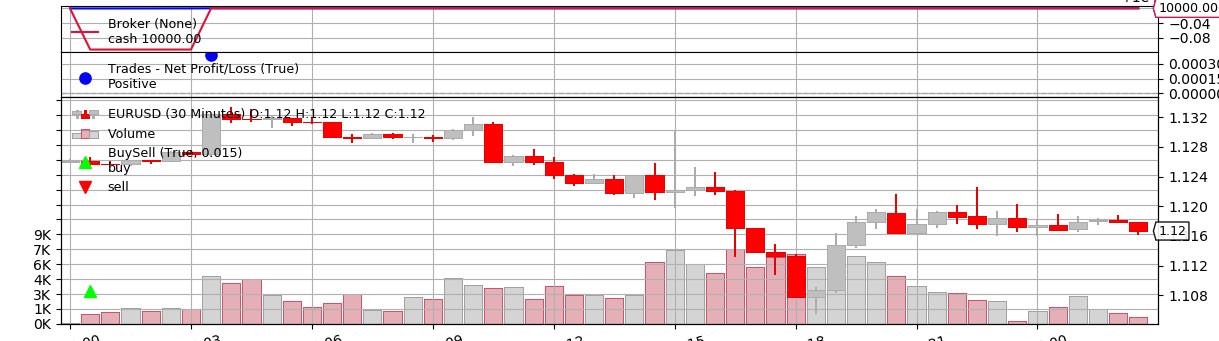

In [10]:
import backtrader as bt
from backtradermql5.mt5store import MTraderStore
from datetime import datetime, timedelta

%matplotlib inline

class SmaCross(bt.SignalStrategy):

    def __init__(self):
        self.buy_order = None
        self.live_data = False

    def next(self):
        if self.buy_order is None:
            self.buy_order = self.buy_bracket(limitprice=1.13, stopprice=1.10, size=0.1, exectype=bt.Order.Market)

        if self.live_data:
            cash = self.broker.getcash()

        # Cancel order
        if self.buy_order is not None:
                self.cancel(self.buy_order[0])

        else:
            # Avoid checking the balance during a backfill. Otherwise, it will
            # Slow things down.
            cash = 'NA'
            #cash = 1000

        for data in self.datas:
            print(f'{data.datetime.datetime()} - {data._name} | Cash N/A | O: {data.open[0]} H: {data.high[0]} L: {data.low[0]} C: {data.close[0]} V:{data.volume[0]}')
            #print(f'{data.datetime.datetime()} - {data._name} | Cash {cash} | O: {data.open[0]} H: {data.high[0]} L: {data.low[0]} C: {data.close[0]} V:{data.volume[0]}')

    def notify_data(self, data, status, *args, **kwargs):
        dn = data._name
        dt = datetime.now()
        msg = f'Data Status: {data._getstatusname(status)}'
        print(dt, dn, msg)
        if data._getstatusname(status) == 'LIVE':
            self.live_data = True
        else:
            self.live_data = False


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross)

    store = MTraderStore(host='192.168.100.110')

    # comment next 2 lines to use backbroker for backtesting with MTraderStore
    #broker = store.getbroker(use_positions=True)
    #cerebro.setbroker(broker)
    
    #start_date = datetime.now() - timedelta(minutes=300)
    #start_date = datetime.now() - timedelta(minutes=1000)
    #start_date = datetime.now() - timedelta(days=100)
    #start_date = datetime.now() - timedelta(days=1)
    start_date = datetime(2020,3,12)
    #start_date = datetime.now() - timedelta(minutes=300)
    data = store.getdata(dataname='EURUSD',
                        timeframe=bt.TimeFrame.Minutes,
                        fromdate=start_date,
                        historical=True
                        )
                        #timeframe=bt.TimeFrame.Minutes,
                        #timeframe=bt.TimeFrame.Days,
                        # todate=datetime.now(),
                        # fromdate=1583625600,
                        # ) #, useask=True,
                        # the parameter "useask" will request the ask price insetad if the default bid price

    # Add the Data Feed to Cerebro
    #cerebro.adddata(data)
    cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=30)

    # Set our desired cash start
    #cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    #cerebro.run(stdstats=False)
    cerebro.run()
    cerebro.plot()
    #cerebro.plot(style='candlestick', volume=True)

    # Print out the final result
    #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Experimenting with strategy and plot the profit

In [ ]:

# Create a Stratey
#--------------------------------------
# strategy sample from backtradermql5
#--------------------------------------
class SmaCross(bt.SignalStrategy):

    def __init__(self):
        self.buy_order = None
        self.live_data = False

    def next(self):
        if self.buy_order is None:
            self.buy_order = self.buy_bracket(limitprice=1.13, stopprice=1.10, size=1000, exectype=bt.Order.Market)

        if self.live_data:
            cash = self.broker.getcash()

        # Cancel order
        if self.buy_order is not None:
            #self.cancel(self.buy_order[0])
            self.sell(size=1000)

        else:
            # Avoid checking the balance during a backfill. Otherwise, it will
            # Slow things down.
            cash = 'NA'

        cash = self.broker.getcash() # Ari
        
        for data in self.datas:
            print(f'{data.datetime.datetime()} - {data._name} | Cash {cash} | O: {data.open[0]} H: {data.high[0]} L: {data.low[0]} C: {data.close[0]} V:{data.volume[0]}')

    def notify_data(self, data, status, *args, **kwargs):
        dn = data._name
        dt = datetime.now()
        msg = f'Data Status: {data._getstatusname(status)}'
        print(dt, dn, msg)
        if data._getstatusname(status) == 'LIVE':
            self.live_data = True
        else:
            self.live_data = False
    
#----
# sample to display the strategy
#----
class St(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data)

#---------------------------------------
# test strategy from backtrader

class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 5),
        ('maperiod', 15),
    )

    def log(self, txt, dt=None, doprint=True):
        ''' Logging function fot this strategy'''
        #if self.params.printlog or doprint:
        if doprint:
            dt = dt or self.datas[0].datetime.datetime()
            print(f'{dt}: {txt}')

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                #self.log('BUY EXECUTED, %.5f' % order.executed.price)
                self.log(
                    'BUY EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                
            elif order.issell():
                #self.log('SELL EXECUTED, %.5f' % order.executed.price)
                self.log('SELL EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.5f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close
                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close

                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('BUY CREATE, %.5f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

        else:
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.5f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
    def stop(self):
        self.log('(Exitbars %2d) Ending Value %.2f' %
                 (self.params.exitbars, self.broker.getvalue()), doprint=True)


        

Starting Portfolio Value: 10000.00
2019-11-20 20:00:00: Close, 1.29215
2019-11-21 00:00:00: Close, 1.29263
2019-11-21 04:00:00: Close, 1.29280
2019-11-21 08:00:00: Close, 1.29435
2019-11-21 08:00:00: BUY CREATE, 1.29435
2019-11-21 12:00:00: BUY EXECUTED, Price: 1.29435, Cost: 500.00, Comm 7.50
2019-11-21 12:00:00: Close, 1.29586
2019-11-21 16:00:00: Close, 1.29038
2019-11-21 16:00:00: SELL CREATE, 1.29038
2019-11-21 20:00:00: SELL EXECUTED, Price: 1.29038, Cost: 1000.00, Comm 15.00
2019-11-21 20:00:00: OPERATION PROFIT, GROSS -198.50, NET -213.50
2019-11-21 20:00:00: Close, 1.29047
2019-11-22 00:00:00: Close, 1.29183
2019-11-22 04:00:00: Close, 1.29208
2019-11-22 08:00:00: Close, 1.28735
2019-11-22 12:00:00: Close, 1.28553
2019-11-22 16:00:00: Close, 1.28273
2019-11-22 20:00:00: Close, 1.28271
2019-11-25 00:00:00: Close, 1.28514
2019-11-25 04:00:00: Close, 1.28520
2019-11-25 08:00:00: Close, 1.28808
2019-11-25 12:00:00: Close, 1.28792
2019-11-25 16:00:00: Close, 1.28882
2019-11-25 20:0

2020-01-08 16:00:00: Close, 1.31047
2020-01-08 20:00:00: Close, 1.30938
2020-01-09 00:00:00: Close, 1.31117
2020-01-09 04:00:00: Close, 1.31165
2020-01-09 08:00:00: Close, 1.30274
2020-01-09 12:00:00: Close, 1.30520
2020-01-09 16:00:00: Close, 1.30613
2020-01-09 20:00:00: Close, 1.30659
2020-01-10 00:00:00: Close, 1.30631
2020-01-10 04:00:00: Close, 1.30822
2020-01-10 08:00:00: Close, 1.30676
2020-01-10 12:00:00: Close, 1.30692
2020-01-10 16:00:00: Close, 1.30616
2020-01-10 20:00:00: Close, 1.30637
2020-01-13 00:00:00: Close, 1.30388
2020-01-13 04:00:00: Close, 1.30327
2020-01-13 08:00:00: Close, 1.29726
2020-01-13 12:00:00: Close, 1.29840
2020-01-13 16:00:00: Close, 1.29951
2020-01-13 20:00:00: Close, 1.29867
2020-01-14 00:00:00: Close, 1.29912
2020-01-14 04:00:00: Close, 1.29886
2020-01-14 08:00:00: Close, 1.29721
2020-01-14 12:00:00: Close, 1.29899
2020-01-14 16:00:00: Close, 1.30212
2020-01-14 20:00:00: Close, 1.30157
2020-01-15 00:00:00: Close, 1.30234
2020-01-15 00:00:00: BUY CRE

<IPython.core.display.Javascript object>


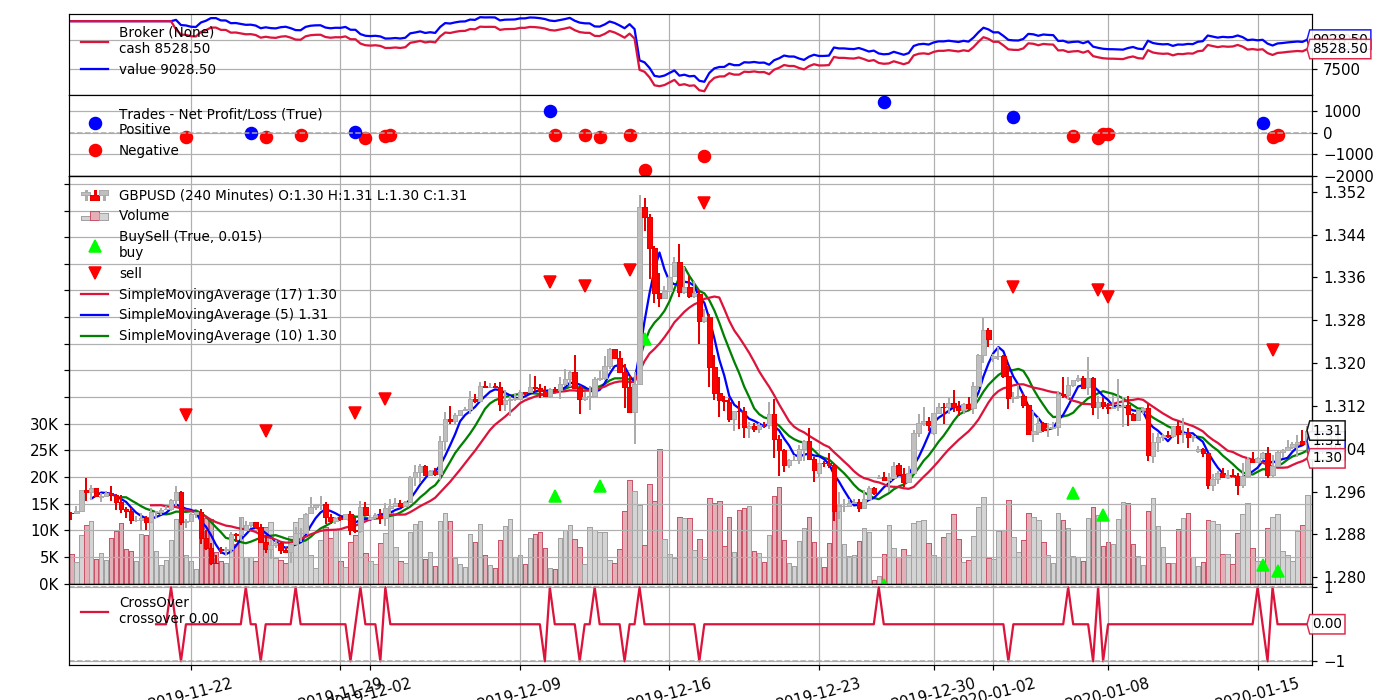

-- Time Return:
2019-12-31: -0.04339999999999378
2020-12-31: -0.056188584570352806
-- Sharpe Ratio:
sharperatio: -9.351197852460169
-- SQN:
sqn: -0.4511540108718383
trades: 24
Final Portfolio Value: 9028.50


In [1]:
import backtrader as bt
from backtradermql5.mt5store import MTraderStore
from datetime import datetime, timedelta

%matplotlib inline

class MySignal(bt.Indicator):
    lines = ('signal',)
    params = (('period', 30),)

    def __init__(self):
        self.lines.signal = self.data - bt.indicators.SMA(period=self.p.period)


class SMAExitSignal(bt.Indicator):
    lines = ('signal',)
    params = (('p1', 5), ('p2', 30),)

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.p1)
        sma2 = bt.indicators.SMA(period=self.p.p2)
        self.lines.signal = sma1 - sma2

##

class MyStrategy(bt.Strategy):
    params = (
        ('maperiod', 30),
        ('fast_sma_period', 5),
        ('slow_sma_period', 30),
    )

    def log(self, txt, dt=None, doprint=True):
        ''' Logging function for this strategy'''
        if doprint:
            dt = dt or self.datas[0].datetime.datetime()
            print(f'{dt}: {txt}')

    def __init__(self):

        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # indicators
        msma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
        fast_sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.fast_sma_period)
        slow_sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.slow_sma_period)

        # entry point
        #self.crossup = bt.ind.CrossUp(self.data.close, msma, plot=True)

        # exit point
        #self.crossdown = bt.ind.CrossDown(fast_sma, slow_sma, plot=True)
        
        # entry and exit point
        self.crossover = bt.ind.CrossOver(self.data.close, msma, plot=True)
        
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.5f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # Not yet ... we MIGHT BUY if .. cross-over (close and entry sma)

            #if self.crossup > 0: 
            #    # SELL, SELL, SELL!!! (with all possible default parameters)
            #    self.log('BUY CREATE, %.5f' % self.dataclose[0])
            #    self.order = self.buy()

            if self.crossover > 0: 
                # BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.5f' % self.dataclose[0])
                self.order = self.buy()
                
            if self.crossover < 0:
                # SELL !!! (with all possible default parameters)
                self.log('SELL CREATE, %.5f' % self.dataclose[0])
                self.order = self.sell()

        else:
            # Already in the market ... we might sell (fast and slow exit sma crossdown)
            #if self.crossdown > 0:
            #    self.log('SELL CREATE, %.5f' % self.dataclose[0])
            #    self.order = self.sell()
            if self.crossover > 0: 
                # BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.5f' % self.dataclose[0])
                self.order = self.buy()
            
            if self.crossover < 0:
                # SELL !!! (with all possible default parameters)
                self.log('SELL CREATE, %.5f' % self.dataclose[0])
                self.order = self.sell()            

    def stop(self):
        self.log('(Entry SMA period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)
        

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    #----- The Store
    store = MTraderStore(host='192.168.100.110', debug=False)

    #comment next 2 lines to use backbroker for backtesting with MTraderStore
    #broker = store.getbroker(use_positions=True)
    #cerebro.setbroker(broker)

    #start_date = datetime.now() - timedelta(minutes=720)
    start_date = datetime.now() - timedelta(days=120)
    end_date   = datetime.now() - timedelta(days=60)
    #start_date = datetime.now() - timedelta(days=360)
    #start_date=datetime(2020,3,1)
    #end_date=datetime(2019,3,1),
    #start_date = datetime(2019,1,1)
    #end_date = datetime(2020,1,1)
    
    #data = store.getdata(dataname='AUDUSD',  ## best result
    #cerebro.add_signal(bt.SIGNAL_LONGSHORT, MySignal, period=17)
    #cerebro.add_signal(bt.SIGNAL_LONGEXIT, SMAExitSignal, p1=5, p2=10)
    
    #data = store.getdata(dataname='GBPUSD',
    #cerebro.add_signal(bt.SIGNAL_LONGSHORT, MySignal, period=47)

    data = store.getdata(dataname='GBPUSD',
                        timeframe=bt.TimeFrame.Minutes, compression=240,
                        fromdate = start_date,
                        todate   = end_date,
                        historical=True
                        )
                        #timeframe=bt.TimeFrame.Minutes,
                        # ) #, useask=True,
                        # the parameter "useask" will request the ask price insetad if the default bid price

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    #cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=15)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(bt.sizers.FixedSize, stake=1)
    cerebro.addsizer(bt.sizers.FixedReverser, stake=0.5)
    #cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
    #cerebro.addsizer(bt.sizers.PercentSizerInt, percents=10)

    #----- Normal Strategy 
    #cerebro.addstrategy(SmaCross)
    #cerebro.addstrategy(St)
    #cerebro.addstrategy(TestStrategy, exitbars=5, maperiod=15) 
    cerebro.addstrategy(MyStrategy, maperiod=17, fast_sma_period=5, slow_sma_period=10)

    #----- Optimizing a strategy
    #strats = cerebro.optstrategy(TestStrategy, exitbars=range(4,8)) 
    #strats = cerebro.optstrategy(MyStrategy, maperiod=range(10,41))
    
    # Add signals
    #cerebro.add_signal(bt.SIGNAL_LONGSHORT, MySignal, period=17)
    #cerebro.add_signal(bt.SIGNAL_LONGEXIT, SMAExitSignal, p1=5, p2=10)

    #cerebro.add_signal(bt.SIGNAL_LONGSHORT, MySignal, period=47)
    
    #----- Set commission
    cerebro.broker.setcommission(commission=15,margin=1000, mult=100000)

    # test analyzer 
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Years)
    cerebro.addanalyzer(bt.analyzers.SQN,)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    #results = cerebro.run(maxcpus=1,stdstats=False)
    results = cerebro.run()
    #cerebro.plot()
    cerebro.plot(style='candlestick', volume=True)

    # analyzer's result
    #strat = results[0][0]
    strat = results[0]

    # Results of own analyzers
    al = strat.analyzers.timereturn
    print('-- Time Return:')
    for k, v in al.get_analysis().items():
        print('{}: {}'.format(k, v))

    al = strat.analyzers.sharperatio
    print('-- Sharpe Ratio:')
    for k, v in al.get_analysis().items():
        print('{}: {}'.format(k, v))

    al = strat.analyzers.sqn
    print('-- SQN:')
    for k, v in al.get_analysis().items():
        print('{}: {}'.format(k, v))
        
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
